In [1]:
import sys
sys.path.insert(0, "..")

from base import *
from util import *

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
import numpy as np

from tensorflow.keras.utils import to_categorical

from fitter import Fitter, get_common_distributions, get_distributions
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.datasets import make_friedman3, make_s_curve
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.neural_network import MLPClassifier

!pip install imbalanced-learn
!pip install lightgbm
!pip install wittgenstein --user
!pip install explainerdashboard --user

from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# for Box-Cox Transformation
from scipy import stats

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px

from tqdm import tqdm
import math

from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame


In [34]:
#Collect data from sensors (i.e., time-series data) installed in the manufacturing system 
ai4i2020_encoded_balanced=pd.read_csv(r'G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\raw_data\\ai4i2020_encoded_balanced.csv')
ai4i2020_encoded_balanced.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,0,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,0,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,0,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,0,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [35]:
ai4i2020_encoded_balanced.dtypes

Type                         int64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [31]:
# Run in local
# Fold index
fold = 1

original_X_train = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\X_train_iter_" + str(fold) + ".csv")
original_X_test = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\X_test_iter_" + str(fold) + ".csv")

X_train = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\Scaled_X_train_iter_" + str(fold) + ".csv", names=['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
y_train = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Training Dataset" + "\\y_train_iter_" + str(fold) + ".csv")
X_test = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\Scaled_X_test_iter_" + str(fold) + ".csv", names=['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
y_test = pd.read_csv('G:\\.shortcut-targets-by-id\\1-wapAl6N5YrCs68c4NiFKyvybXTXmdgZ\\Ph_D_Tyrovolas\\Our Papers\\3rd_Paper-Proposal\\Testbed Codes\\AI4I_Case_Study\\k-fold cross validation datasets\\' + str(fold) + "\\Test Dataset" + "\\y_test_iter_" + str(fold) + ".csv")

In [32]:
original_X_test.dtypes

Type                       float64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
dtype: object

In [37]:
ai4i2020_encoded_balanced = ai4i2020_encoded_balanced.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
original_X_train = original_X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
original_X_test = original_X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train = y_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_test = y_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [38]:
ai4i2020_encoded_balanced.columns


Index(['Type', 'AirtemperatureK', 'ProcesstemperatureK', 'Rotationalspeedrpm',
       'TorqueNm', 'Toolwearmin', 'Machinefailure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [39]:
acc_list = []
auc_list = []
kappa_list = []

## Training 

### FCMB Classifier

In [ ]:
# Build an FCMB model


from sklearn.base import BaseEstimator, ClassifierMixin
from base.classifier import BaseFcmClassifier
from base.losses import MSE, LogLoss, SoftmaxCrossEntropy
from base.model import Model, AdditiveModel, Sigmoid, Tanh, Ident, Relu
from base.binary_classifier import FcmBinaryClassifier
import tensorflow as tf
import sklearn.preprocessing
import numpy as np

X = X_train.to_numpy()
y = y_train.to_numpy()

fcmb = FcmBinaryClassifier()

fcmb.__init__(act=None, activation='sigmoid', activation_m=1, depth=2, epochs=3300, batch_size=-1, buffer_size=1000, training_loss='logloss', optimizer='rmsprop', learning_rate=0.004, model_type='basic', init_method = None, init_y_method = 'uniform', dropout_p=0.0, training_hook=[], random_state=None)

fcmb.fit(X,y)

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 2, 'dropout_p': 0.0, 'epochs': 3300, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.004, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


### FCMMC Classifier 

In [48]:
# Build an FCMMC model

from sklearn.base import BaseEstimator, ClassifierMixin
from base.classifier import BaseFcmClassifier
from base.losses import MSE, LogLoss, SoftmaxCrossEntropy
from base.model import Model, AdditiveModel, Sigmoid, Tanh, Ident, Relu
from base.mc_classifier import FcmMulticlassClassifier
import tensorflow as tf
import sklearn.preprocessing
import numpy as np
       
fcmmc = FcmMulticlassClassifier()
fcmmc.fit(X,y)

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': 10, 'buffer_size': 1000, 'depth': 5, 'dropout_p': 0.0, 'epochs': 100, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.001, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'softmax'}
-----------------------------------------
Learning time 3747.1306698322296 sec



FcmMulticlassClassifier()

### FCMB Classifier 

In [49]:
#Predict the FCMB response for train dataset
y_train_pred_fcmb = fcmb.predict(X_train)

#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train,y_train_pred_fcmb))
print("Recall Score: ",recall_score(y_train, y_train_pred_fcmb))
print("F1 Score: ",f1_score(y_train, y_train_pred_fcmb))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_fcmb))

Precision Score:  0.9145751784480773
Recall Score:  0.9637267984956933
F1 Score:  0.9385078858763068
Accuracy Score:  0.933929931454684


<AxesSubplot:>

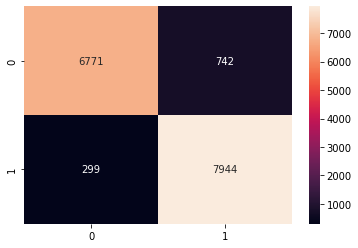

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_fcmb)
sns.heatmap(confusion_matrix(y_train, y_train_pred_fcmb), annot=True,fmt='d')

#### Evaluating on Test set  (FCMB Classifier)

In [51]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_fcmb = fcmb.predict(X_test)


print("Precision Score: ",precision_score(y_test, y_test_pred_fcmb))
print("Recall Score: ",recall_score(y_test, y_test_pred_fcmb))
print("F1 Score: ",f1_score(y_test, y_test_pred_fcmb))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_fcmb))

Precision Score:  0.9177083333333333
Recall Score:  0.9617903930131004
F1 Score:  0.9392324093816631
Accuracy Score:  0.9348943460879497


<AxesSubplot:>

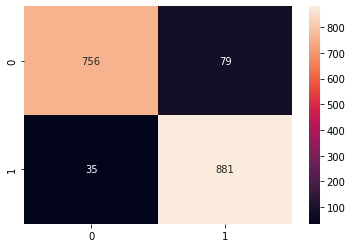

In [52]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred_fcmb)
sns.heatmap(confusion_matrix(y_test, y_test_pred_fcmb), annot=True,fmt='d')

In [53]:
from sklearn import metrics
#calculate AUC of model
auc_fcmb = metrics.roc_auc_score(y_test, y_test_pred_fcmb)
print(auc_fcmb)

0.9335898072849933


#### FCMB Classifier's Cohen Kappa 

In [54]:
cohen_score_fcmb = cohen_kappa_score(y_test, y_test_pred_fcmb)
print(cohen_score_fcmb)

0.8692047208804342


In [55]:
acc_list.append(accuracy_score(y_test, y_test_pred_fcmb))
auc_list.append(auc_fcmb)
kappa_list.append(cohen_score_fcmb)

In [56]:
# Binary FCM Classifier Weights
fcmb.base_fcm.model.W

<tf.Variable 'Variable:0' shape=(7, 7) dtype=float64, numpy=
array([[-0.97575876,  2.92787467, -1.56578642, -2.09422522,  5.61148749,
         2.74718549, -0.23981631],
       [-0.22577434, -1.35966391,  2.62930414,  7.4867911 , -6.34334593,
        -3.2246031 , -0.41157507],
       [-0.11579755, -2.05360643,  1.20733851,  2.50932905, -6.56816978,
         5.40145113,  0.04394094],
       [ 0.68223025,  0.56166061,  0.18262722, -6.62934647, 10.75079909,
         2.68530295,  0.22207764],
       [-0.363194  , -2.00296621,  0.80515667,  5.75599736, -6.68812704,
        -5.25387997, -0.06406627],
       [ 0.74950863,  6.16339719, -3.35896973,  0.290081  , -0.90856562,
        -8.2860833 ,  0.31895275],
       [ 9.3115966 , -2.830295  , 11.84978519, -8.24781781, -5.75362431,
         6.87000817,  0.71951169]])>

In [57]:
# Binary FCM Classifier bias
fcmb.base_fcm.model.b

<tf.Variable 'Variable:0' shape=(7, 1) dtype=float64, numpy=
array([[-4.03762405],
       [ 2.31869999],
       [-3.05693747],
       [ 4.59914961],
       [ 2.1204542 ],
       [ 0.7324532 ],
       [ 3.06160143]])>

In [58]:
# Binary FCM Classifier inference process for each observation of the training dataset

init_y = np.ones((X.shape[0], fcmb.base_fcm.model.dim - X.shape[1])) * .5

trj_fcmb = fcmb.base_fcm.model.trajectory(X, init_y)

trj_fcmb

[array([[0.03489692, 0.51641602, 0.6600942 , ..., 0.62967   , 0.86352839,
         0.5       ],
        [0.03489692, 0.04256139, 0.04288691, ..., 0.01300837, 0.86352839,
         0.5       ],
        [0.88111716, 0.80309573, 0.75243418, ..., 0.60365046, 0.51043227,
         0.5       ],
        ...,
        [0.03489692, 0.91093581, 0.89522358, ..., 0.60004257, 0.8238796 ,
         0.5       ],
        [0.03489692, 0.52516814, 0.78478205, ..., 0.45123594, 0.1385033 ,
         0.5       ],
        [0.88111716, 0.14004244, 0.07461111, ..., 0.23605089, 0.63226586,
         0.5       ]]),
 array([[0.73490671, 0.14996566, 0.07814487, ..., 0.00294119, 0.00192589,
         0.99990545],
        [0.01361293, 0.99812916, 0.97106956, ..., 0.93444226, 0.00176003,
         0.77626202],
        [0.45804442, 0.27279628, 0.00776622, ..., 0.00843888, 0.22825418,
         0.99999979],
        ...,
        [0.83217515, 0.16988733, 0.04322276, ..., 0.00200124, 0.01388653,
         0.99998502],
        [0.0

In [59]:
#We have d arrays where each array(i), for i=0,1,...,d-1 contains the ith state vector for each data observation

init_y_test = np.ones((X_test.shape[0], fcmb.base_fcm.model.dim - X_test.shape[1])) * .5

trj_fcmb_test = fcmb.base_fcm.model.trajectory(X_test, init_y_test)

trj_fcmb_test

np.shape(trj_fcmb_test)

(3, 1751, 7)

In [60]:
trj_fcmb_test

[array([[0.03489692, 0.14004244, 0.26256008, ..., 0.70030832, 0.28282248,
         0.5       ],
        [0.88111716, 0.30642803, 0.34283657, ..., 0.51496324, 0.84752158,
         0.5       ],
        [0.03489692, 0.16407757, 0.36106921, ..., 0.94439403, 0.22337481,
         0.5       ],
        ...,
        [0.88111716, 0.76087163, 0.73259553, ..., 0.06219359, 0.11142219,
         0.5       ],
        [0.88111716, 0.91752604, 0.92281651, ..., 0.40776416, 0.30765751,
         0.5       ],
        [0.03489692, 0.60396651, 0.48248274, ..., 0.20200808, 0.18834115,
         0.5       ]]),
 array([[3.14508826e-01, 3.98029915e-01, 3.57118295e-03, ...,
         7.70639329e-02, 7.79445895e-02, 6.79403039e-01],
        [3.34446498e-01, 1.94307909e-01, 1.46898437e-01, ...,
         7.34064778e-03, 3.69402495e-03, 9.99999339e-01],
        [5.80998459e-01, 1.84675603e-01, 5.71751401e-04, ...,
         2.35098811e-02, 8.46910177e-02, 4.93136978e-01],
        ...,
        [2.87648271e-03, 9.99869037e

In [61]:
#The last array contains the state vector in the last cycle for each data instance
#Remember that the defined threshold is 0.5

trj_fcmb_test[fcmb.depth][12]

array([1.66109020e-01, 9.91833494e-01, 3.63402901e-03, 9.62599959e-01,
       9.02387952e-01, 9.95931499e-01, 1.48017363e-04])

In [62]:
y_test_pred_fcmb[12]

array([0])

In [63]:
local_feature_importance_fcmb = pd.DataFrame(trj_fcmb_test[fcmb.depth], columns=['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure'])
local_feature_importance_fcmb.drop('Machine failure', inplace=True, axis=1)


### FCMMC Classifier 

In [64]:
#Predict the FCMB response for train dataset
y_train_pred_fcmmc = fcmmc.predict(X_train)

#Performance measures for training dataset

from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
print("Precision Score: ",precision_score(y_train,y_train_pred_fcmmc))
print("Recall Score: ",recall_score(y_train, y_train_pred_fcmmc))
print("F1 Score: ",f1_score(y_train, y_train_pred_fcmmc))
print("Accuracy Score: ",accuracy_score(y_train, y_train_pred_fcmmc))

Precision Score:  0.9156642974302898
Recall Score:  0.8126895547737474
F1 Score:  0.861109325792146
Accuracy Score:  0.8628458999746128


<AxesSubplot:>

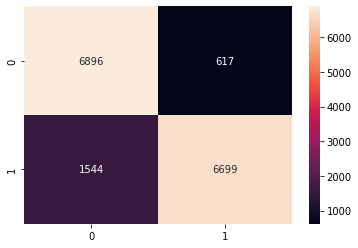

In [65]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred_fcmmc)
sns.heatmap(confusion_matrix(y_train, y_train_pred_fcmmc), annot=True,fmt='d')

#### Evaluating on Test set  (FCMMC Classifier)

In [66]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

#Predict the response for test dataset
y_test_pred_fcmmc = fcmmc.predict(X_test)


print("Precision Score: ",precision_score(y_test, y_test_pred_fcmmc))
print("Recall Score: ",recall_score(y_test, y_test_pred_fcmmc))
print("F1 Score: ",f1_score(y_test, y_test_pred_fcmmc))
print("Accuracy Score: ",accuracy_score(y_test, y_test_pred_fcmmc))

Precision Score:  0.9055023923444976
Recall Score:  0.8264192139737991
F1 Score:  0.8641552511415524
Accuracy Score:  0.8640776699029126


<AxesSubplot:>

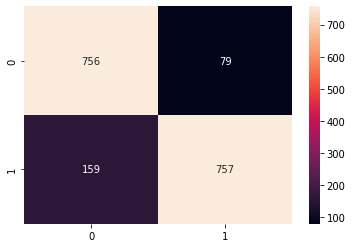

In [67]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred_fcmmc)
sns.heatmap(confusion_matrix(y_test, y_test_pred_fcmmc), annot=True,fmt='d')

In [68]:
from sklearn import metrics
#calculate AUC of model
auc_fcmmc = metrics.roc_auc_score(y_test, y_test_pred_fcmmc)
print(auc_fcmmc)

0.8659042177653427


In [69]:
cohen_score_fcmmc = cohen_kappa_score(y_test, y_test_pred_fcmmc)
print(cohen_score_fcmmc)

0.7287215206353339


In [70]:
acc_list.append(accuracy_score(y_test, y_test_pred_fcmmc))
auc_list.append(auc_fcmmc)
kappa_list.append(cohen_score_fcmmc)

In [71]:
# MultiClass FCM Classifier Weights
fcmmc.base_fcm.model.W

<tf.Variable 'Variable:0' shape=(8, 8) dtype=float64, numpy=
array([[ 1.31270853e+00, -8.76309613e-02, -5.47381348e-01,
         2.96901776e+00, -3.50496727e+00, -3.19826371e-01,
         4.18673008e-02,  1.21412581e-01],
       [ 6.07346514e-03,  1.66052161e+00,  6.14999429e-01,
        -1.95669644e+00,  2.53191787e+00, -3.43282186e+00,
        -9.48298085e-01,  1.57253643e-01],
       [-1.14389723e+00,  2.28998622e+00,  2.29002095e+00,
        -5.49875968e+00,  1.75416503e+00, -1.45123152e-03,
         1.40013142e+00,  3.85399617e-01],
       [ 6.89030271e-01, -6.87946438e-01,  1.61331594e+00,
         2.02024138e+00, -2.02159163e+00, -1.61719267e+00,
        -6.53521737e-01, -3.11024716e-01],
       [-4.61917794e-01,  1.21060497e+00, -2.60025127e-01,
        -2.22755125e+00,  2.91252578e+00,  1.25630721e+00,
        -8.80287893e-02, -1.42135416e-01],
       [ 7.79609631e-01,  3.55672128e+00,  2.53439176e-01,
         1.46723148e+00, -6.13363437e+00,  1.87564470e+00,
         6.45960

In [72]:
# MultiClass FCM Classifier bias
fcmmc.base_fcm.model.b

<tf.Variable 'Variable:0' shape=(8, 1) dtype=float64, numpy=
array([[ 0.99750563],
       [-0.822348  ],
       [ 0.00286992],
       [ 0.70475854],
       [-0.65403882],
       [ 0.15925434],
       [ 0.1082356 ],
       [-0.11184512]])>

In [73]:
# MultiClass FCM Classifier inference process for each observation of the training dataset

init_y = np.ones((X.shape[0], fcmmc.base_fcm.model.dim - X.shape[1])) * .5

trj_fcmmc = fcmmc.base_fcm.model.trajectory(X, init_y)

trj_fcmmc


[array([[0.03489692, 0.51641602, 0.6600942 , ..., 0.86352839, 0.5       ,
         0.5       ],
        [0.03489692, 0.04256139, 0.04288691, ..., 0.86352839, 0.5       ,
         0.5       ],
        [0.88111716, 0.80309573, 0.75243418, ..., 0.51043227, 0.5       ,
         0.5       ],
        ...,
        [0.03489692, 0.91093581, 0.89522358, ..., 0.8238796 , 0.5       ,
         0.5       ],
        [0.03489692, 0.52516814, 0.78478205, ..., 0.1385033 , 0.5       ,
         0.5       ],
        [0.88111716, 0.14004244, 0.07461111, ..., 0.63226586, 0.5       ,
         0.5       ]]),
 array([[2.12341883e-01, 7.92260929e-02, 9.15795328e-01, ...,
         5.53717310e-01, 4.51334930e-02, 9.59909730e-01],
        [9.62490392e-01, 1.48825200e-03, 7.20552944e-03, ...,
         9.58990624e-01, 9.99294264e-01, 1.74909380e-03],
        [4.61247222e-01, 3.28824396e-01, 9.16559827e-01, ...,
         7.98087879e-01, 7.05803061e-03, 9.60961745e-01],
        ...,
        [1.89014330e-01, 1.78435257e

In [74]:
init_y = np.ones((X.shape[0], fcmmc.base_fcm.model.dim - X.shape[1])) * .5

np.shape(init_y)

(15756, 2)

In [75]:
#We have d arrays where each array(i), for i=0,1,...,d contains the ith state vector for each data observation

init_y_test = np.ones((X_test.shape[0], fcmmc.base_fcm.model.dim - X_test.shape[1])) * .5

trj_fcmmc_test = fcmmc.base_fcm.model.trajectory(X_test, init_y_test)

trj_fcmmc_test

np.shape(trj_fcmmc_test)

(6, 1751, 8)

In [76]:
trj_fcmmc_test

[array([[0.03489692, 0.14004244, 0.26256008, ..., 0.28282248, 0.5       ,
         0.5       ],
        [0.88111716, 0.30642803, 0.34283657, ..., 0.84752158, 0.5       ,
         0.5       ],
        [0.03489692, 0.16407757, 0.36106921, ..., 0.22337481, 0.5       ,
         0.5       ],
        ...,
        [0.88111716, 0.76087163, 0.73259553, ..., 0.11142219, 0.5       ,
         0.5       ],
        [0.88111716, 0.91752604, 0.92281651, ..., 0.30765751, 0.5       ,
         0.5       ],
        [0.03489692, 0.60396651, 0.48248274, ..., 0.18834115, 0.5       ,
         0.5       ]]),
 array([[0.27857743, 0.22054409, 0.60421573, ..., 0.06526184, 0.22123806,
         0.88255677],
        [0.6242189 , 0.03562535, 0.45249333, ..., 0.68464738, 0.9543647 ,
         0.01300212],
        [0.13935428, 0.41208726, 0.74812131, ..., 0.01554298, 0.04982819,
         0.98142927],
        ...,
        [0.98100813, 0.10390323, 0.07516437, ..., 0.99191682, 0.03909393,
         0.86892566],
        [0.7

In [77]:
#The last array contains the last cycle's state/activation vector for each data instance
#Remember that the label is predicted based on the maximum output value value.

trj_fcmmc_test[fcmmc.depth][162]

array([6.38631174e-01, 1.45501103e-02, 4.68233374e-01, 2.75379182e-01,
       4.61292377e-01, 5.96538926e-01, 9.98752417e-01, 4.09824976e-04])

In [78]:
y_test_pred_fcmmc[162]

0

In [79]:
local_feature_importance_fcmmc = pd.DataFrame(trj_fcmmc_test[fcmmc.depth], columns=['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', '0', '1'])
local_feature_importance_fcmmc.drop('0', inplace=True, axis=1)
local_feature_importance_fcmmc.drop('1', inplace=True, axis=1)

## Local Explanations for both models

### FCMB Classifier

In [80]:
#Find the observations' indexes that the model correctly predicted as faulty
#y: Expected values of the model's output
y=y_test;
true_positive_indexes = []
i=1;

#According to the chosen model
#For example, y_test_pred_lgbmc for LGBM Classifier
for k in range(0,len(y)):
    if (y.loc[k,'Machine failure']==int(y_test_pred_fcmb[k])) and (y.loc[k,'Machine failure']==1):
        true_positive_indexes.append(k)
        i=i+1;

        
#Find the observations that the selected model correctly predicted as faulty based on the previous indexes
true_positive_observations = pd.DataFrame()
for k in range(0,len(true_positive_indexes)):
    new_row = pd.concat([original_X_test.loc[true_positive_indexes[k],:],y.loc[true_positive_indexes[k],:]], axis=0)
    true_positive_observations = true_positive_observations.append(new_row, ignore_index=True)

    
#Find the observations that the selected model correctly predicted correctly as faulty along with the failure modes

true_positive_observations_with_failure_modes = pd.DataFrame()
#for index1 in range(0,len(true_positive_observations)):
    #for index2 in range (0,len(ai4i2020_encoded_balanced)):
        #if true_positive_observations.loc[index1,:].equals(ai4i2020_encoded_balanced.loc[index2,"Type":"Machine failure"]) == True:
            #print(index1)
            #true_positive_observations_with_failure_modes = true_positive_observations_with_failure_modes.append(ai4i2020_encoded_balanced.loc[index2,:], ignore_index=True)
true_positive_observations_with_failure_modes = ai4i2020_encoded_balanced.join(true_positive_observations.set_index(['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Machine failure']), ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Machine failure'], how='right')       
final_true_positive_observations_with_failure_modes = true_positive_observations_with_failure_modes.reset_index(drop=True)

display("Number of true positive predictions: " + str(len(final_true_positive_observations_with_failure_modes)))

number_of_TWF_failures_in_true_positive_predictions = 0
number_of_HDF_failures_in_true_positive_predictions = 0
number_of_PWF_failures_in_true_positive_predictions = 0
number_of_OSF_failures_in_true_positive_predictions = 0
number_of_random_failures_in_true_positive_predictions=0

for k in range(0,len(final_true_positive_observations_with_failure_modes)):
    if final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==1: #if the failure mode is TWF
        number_of_TWF_failures_in_true_positive_predictions = number_of_TWF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==1: #if the failure mode is HDF
        number_of_HDF_failures_in_true_positive_predictions = number_of_HDF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==1: #if the failure mode is PWF
        number_of_PWF_failures_in_true_positive_predictions = number_of_PWF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==1: #if the failure mode is OSF
        number_of_OSF_failures_in_true_positive_predictions = number_of_OSF_failures_in_true_positive_predictions + 1;
    if (final_true_positive_observations_with_failure_modes.loc[k,"Machine failure"]==1) and (final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"RNF"]==0):
        number_of_random_failures_in_true_positive_predictions = number_of_random_failures_in_true_positive_predictions+1;

display("Number of TWF failures: " + str(number_of_TWF_failures_in_true_positive_predictions))
display("Number of HDF failures: " + str(number_of_HDF_failures_in_true_positive_predictions))
display("Number of PWF failures: " + str(number_of_PWF_failures_in_true_positive_predictions))
display("Number of OSF failures: " + str(number_of_OSF_failures_in_true_positive_predictions))
display("Number of RNF failures: " + str(number_of_random_failures_in_true_positive_predictions))

'Number of true positive predictions: 881'

'Number of TWF failures: 68'

'Number of HDF failures: 248'

'Number of PWF failures: 131'

'Number of OSF failures: 252'

'Number of RNF failures: 191'

In [81]:
#Interacitve Widget in order to see each true positive observation along with the failure modes

from IPython.display import display
from IPython.display import clear_output
from ipywidgets import Output
from ipywidgets import widgets


text = widgets.Text()
display(text)

out = widgets.Output()
display(out)

def handle_submit(sender):
    with out:
        clear_output()
        index = int(text.value)
        print(final_true_positive_observations_with_failure_modes.loc[index,:])
        print('\n')
        print("Dataset index for the above true positive observation (starting from 0 index): " + str(true_positive_indexes[index]))
        
text.on_submit(handle_submit)

Text(value='')

Output()

In [82]:
#Calculate the correct explanations
correct_explanations = 0
correct_explanations_TWF = 0
correct_explanations_HDF = 0
correct_explanations_PWF = 0
correct_explanations_OSF = 0

for k in range(0,len(true_positive_observations)):
    #if the failure mode is TWF
    if final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==1:
        #if tool wear is the most important feature
        if local_feature_importance_fcmb.loc[true_positive_indexes[k],"Tool wear [min]"] == max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]):
            correct_explanations = correct_explanations+1;
            correct_explanations_TWF = correct_explanations_TWF + 1;
    
    #if the failure mode is HDF
    if final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==1: 
        maximum1 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]) 
        maximum2 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmb.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
        if (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Air temperature [K]"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Air temperature [K]"] == maximum2) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Process temperature [K]"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Process temperature [K]"] == maximum2):
            correct_explanations = correct_explanations+1;
            correct_explanations_HDF = correct_explanations_HDF + 1;
            
    #if the failure mode is PWF
    if final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==1: 
        maximum1 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]) 
        maximum2 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmb.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
        if (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Rotational speed [rpm]"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Rotational speed [rpm]"] == maximum2) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum2):
            correct_explanations = correct_explanations+1;
            correct_explanations_PWF = correct_explanations_PWF + 1;
            
    #if the failure mode is OSF        
    if final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==1:
        maximum1 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]) 
        maximum2 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmb.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
        if (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Tool wear [min]"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Tool wear [min]"] == maximum2) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum2):
            correct_explanations = correct_explanations+1;
            correct_explanations_OSF = correct_explanations_OSF + 1;

print("TWF: %.4f success, HDF: %.4f success, PWF: %.4f success, OSF: %.4f success \n\n" % (correct_explanations_TWF/number_of_TWF_failures_in_true_positive_predictions,correct_explanations_HDF/number_of_HDF_failures_in_true_positive_predictions,correct_explanations_PWF/number_of_PWF_failures_in_true_positive_predictions,correct_explanations_OSF/number_of_OSF_failures_in_true_positive_predictions))

average_success = ((correct_explanations_TWF/number_of_TWF_failures_in_true_positive_predictions)+(correct_explanations_HDF/number_of_HDF_failures_in_true_positive_predictions)+(correct_explanations_PWF/number_of_PWF_failures_in_true_positive_predictions)+(correct_explanations_OSF/number_of_OSF_failures_in_true_positive_predictions))/4

print("Through the FCMB model, %d correct explanations are made in the true positive predictions with average success: %.4f \n\n" % (correct_explanations, average_success))


TWF: 0.0000 success, HDF: 1.0000 success, PWF: 1.0000 success, OSF: 1.0000 success 


Through the FCMB model, 631 correct explanations are made in the true positive predictions with average success: 0.7500 




### FCMMC Classifier 

In [83]:
#Find the observations' indexes that the model correctly predicted as faulty
#y: Expected values of the model's output
y=y_test;
true_positive_indexes = []
i=1;

#According to the chosen model
#For example, y_test_pred_lgbmc for LGBM Classifier
for k in range(0,len(y)):
    if (y.loc[k,'Machine failure']==int(y_test_pred_fcmmc[k])) and (y.loc[k,'Machine failure']==1):
        true_positive_indexes.append(k)
        i=i+1;

        
#Find the observations that the selected model correctly predicted as faulty based on the previous indexes
true_positive_observations = pd.DataFrame()
for k in range(0,len(true_positive_indexes)):
    new_row = pd.concat([original_X_test.loc[true_positive_indexes[k],:],y.loc[true_positive_indexes[k],:]], axis=0)
    true_positive_observations = true_positive_observations.append(new_row, ignore_index=True)

    
#Find the observations that the selected model correctly predicted correctly as faulty along with the failure modes

true_positive_observations_with_failure_modes = pd.DataFrame()
#for index1 in range(0,len(true_positive_observations)):
    #for index2 in range (0,len(ai4i2020_encoded_balanced)):
        #if true_positive_observations.loc[index1,:].equals(ai4i2020_encoded_balanced.loc[index2,"Type":"Machine failure"]) == True:
            #print(index1)
            #true_positive_observations_with_failure_modes = true_positive_observations_with_failure_modes.append(ai4i2020_encoded_balanced.loc[index2,:], ignore_index=True)
true_positive_observations_with_failure_modes = ai4i2020_encoded_balanced.join(true_positive_observations.set_index(['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Machine failure']), ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Machine failure'], how='right')       
final_true_positive_observations_with_failure_modes = true_positive_observations_with_failure_modes.reset_index(drop=True)

display("Number of true positive predictions: " + str(len(final_true_positive_observations_with_failure_modes)))

number_of_TWF_failures_in_true_positive_predictions = 0
number_of_HDF_failures_in_true_positive_predictions = 0
number_of_PWF_failures_in_true_positive_predictions = 0
number_of_OSF_failures_in_true_positive_predictions = 0
number_of_random_failures_in_true_positive_predictions=0

for k in range(0,len(final_true_positive_observations_with_failure_modes)):
    if final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==1: #if the failure mode is TWF
        number_of_TWF_failures_in_true_positive_predictions = number_of_TWF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==1: #if the failure mode is HDF
        number_of_HDF_failures_in_true_positive_predictions = number_of_HDF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==1: #if the failure mode is PWF
        number_of_PWF_failures_in_true_positive_predictions = number_of_PWF_failures_in_true_positive_predictions + 1;
    if final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==1: #if the failure mode is OSF
        number_of_OSF_failures_in_true_positive_predictions = number_of_OSF_failures_in_true_positive_predictions + 1;
    if (final_true_positive_observations_with_failure_modes.loc[k,"Machine failure"]==1) and (final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"RNF"]==0):
        number_of_random_failures_in_true_positive_predictions = number_of_random_failures_in_true_positive_predictions+1;

display("Number of TWF failures: " + str(number_of_TWF_failures_in_true_positive_predictions))
display("Number of HDF failures: " + str(number_of_HDF_failures_in_true_positive_predictions))
display("Number of PWF failures: " + str(number_of_PWF_failures_in_true_positive_predictions))
display("Number of OSF failures: " + str(number_of_OSF_failures_in_true_positive_predictions))
display("Number of RNF failures: " + str(number_of_random_failures_in_true_positive_predictions))

'Number of true positive predictions: 757'

'Number of TWF failures: 18'

'Number of HDF failures: 243'

'Number of PWF failures: 73'

'Number of OSF failures: 249'

'Number of RNF failures: 183'

In [84]:
#Interacitve Widget in order to see each true positive observation along with the failure modes

from IPython.display import display
from IPython.display import clear_output
from ipywidgets import Output
from ipywidgets import widgets


text = widgets.Text()
display(text)

out = widgets.Output()
display(out)

def handle_submit(sender):
    with out:
        clear_output()
        index = int(text.value)
        print(final_true_positive_observations_with_failure_modes.loc[index,:])
        print('\n')
        print("Dataset index for the above true positive observation (starting from 0 index): " + str(true_positive_indexes[index]))
        
text.on_submit(handle_submit)

Text(value='')

Output()

In [85]:
#Calculate the correct explanations
correct_explanations = 0
correct_explanations_TWF = 0
correct_explanations_HDF = 0
correct_explanations_PWF = 0
correct_explanations_OSF = 0

for k in range(0,len(true_positive_observations)):
    #if the failure mode is TWF
    if final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==1:
        #if tool wear is the most important feature
        if local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Tool wear [min]"] == max(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:]):
            correct_explanations = correct_explanations+1;
            correct_explanations_TWF = correct_explanations_TWF + 1;
    
    #if the failure mode is HDF
    if final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==1: 
        maximum1 = max(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:]) 
        maximum2 = max(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
        if (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Air temperature [K]"] == maximum1) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Air temperature [K]"] == maximum2) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Process temperature [K]"] == maximum1) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Process temperature [K]"] == maximum2):
            correct_explanations = correct_explanations+1;
            correct_explanations_HDF = correct_explanations_HDF + 1;
            
    #if the failure mode is PWF
    if final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==1: 
        maximum1 = max(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:]) 
        maximum2 = max(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
        if (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Rotational speed [rpm]"] == maximum1) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Rotational speed [rpm]"] == maximum2) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum1) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum2):
            correct_explanations = correct_explanations+1;
            correct_explanations_PWF = correct_explanations_PWF + 1;
            
    #if the failure mode is OSF        
    if final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==1:
        maximum1 = max(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:]) 
        maximum2 = max(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmmc.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
        if (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Tool wear [min]"] == maximum1) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Tool wear [min]"] == maximum2) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum1) or (local_feature_importance_fcmmc.loc[true_positive_indexes[k],"Torque [Nm]"] == maximum2):
            correct_explanations = correct_explanations+1;
            correct_explanations_OSF = correct_explanations_OSF + 1;

print("TWF: %.4f success, HDF: %.4f success, PWF: %.4f success, OSF: %.4f success \n\n" % (correct_explanations_TWF/number_of_TWF_failures_in_true_positive_predictions,correct_explanations_HDF/number_of_HDF_failures_in_true_positive_predictions,correct_explanations_PWF/number_of_PWF_failures_in_true_positive_predictions,correct_explanations_OSF/number_of_OSF_failures_in_true_positive_predictions))

average_success = ((correct_explanations_TWF/number_of_TWF_failures_in_true_positive_predictions)+(correct_explanations_HDF/number_of_HDF_failures_in_true_positive_predictions)+(correct_explanations_PWF/number_of_PWF_failures_in_true_positive_predictions)+(correct_explanations_OSF/number_of_OSF_failures_in_true_positive_predictions))/4

print("Through the FCMMC model, %d correct explanations are made in the true positive predictions with average success: %.4f \n\n" % (correct_explanations, average_success))


TWF: 0.1667 success, HDF: 0.5350 success, PWF: 0.5753 success, OSF: 0.9799 success 


Through the FCMMC model, 419 correct explanations are made in the true positive predictions with average success: 0.5642 




Collecting output labels before the FCM converges to an equilibrium point, leads to a confusing interpretation of the investigated system.

In [86]:
Simulations_for_all_observations_fcmb = []
Simulations_for_all_observations_fcmmc = []

#For the FCMB Classifier
for k in range(0,len(y_test)):
    Simulation_for_each_obervation_fcmb = []
    for iteration in range(0,fcmb.depth):
        Simulation_for_each_obervation_fcmb.append(trj_fcmb_test[iteration][k])
    Simulations_for_all_observations_fcmb.append(Simulation_for_each_obervation_fcmb)
    
#For the FCMMC Classifier
for k in range(0,len(y_test)):
    Simulation_for_each_obervation_fcmmc = []
    for iteration in range(0,fcmmc.depth):
        Simulation_for_each_obervation_fcmmc.append(trj_fcmmc_test[iteration][k])
    Simulations_for_all_observations_fcmmc.append(Simulation_for_each_obervation_fcmmc)

In [87]:
model_list = ['FCMB', 'FCMMC']

#accuracy and AUC
result_df = pd.DataFrame({'Model':model_list, 'Accuracy': acc_list, 'AUC': auc_list, 'Kappa':kappa_list})
final_df = result_df.sort_values(by=['AUC'], ascending=False)
final_df = final_df.reset_index(drop=True)
final_df

,Model,Accuracy,AUC,Kappa
0,FCMB,0.934894,0.933590,0.869205
1,FCMMC,0.864078,0.865904,0.728722


In [88]:
#Plot the Inference Process for FCMB model

#iterations = np.arange(0,6)
#for k in range(0,len(y_test)):
#    fig, ax = plt.subplots()
#    plt.title("Inference Process") 
#    plt.xlabel("Iterations") 
#    plt.ylabel("Concepts") 
#    plt.plot(iterations,Simulations_for_all_observations_fcmb[k]) 
#    plt.show()

In [89]:
#Plot the Inference Process for FCMMC model

#iterations = np.arange(0,6)
#for k in range(0,len(y_test)):
#    fig, ax = plt.subplots()
#    plt.title("Inference Process") 
#    plt.xlabel("Iterations") 
#    plt.ylabel("Concepts") 
#    plt.plot(iterations,Simulations_for_all_observations_fcmmc[k]) 
#    plt.show()

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from base.classifier import BaseFcmClassifier
from base.losses import MSE, LogLoss, SoftmaxCrossEntropy
from base.model import Model, AdditiveModel, Sigmoid, Tanh, Ident, Relu
from base.binary_classifier import FcmBinaryClassifier
import tensorflow as tf
import sklearn.preprocessing
import numpy as np


fcmb_param_grid = {'act': [None],
               'activation': ['sigmoid'],
               'activation_m': [1],
               'depth': [3, 5],
               'epochs': [100, 500, 2000, 3300],
               'batch_size': [-1, 10],
               'buffer_size': [1000],
               'training_loss': ['logloss'],
               'optimizer': ['rmsprop'],
               'learning_rate': [0.001, 0.004, 0.008, 0.06],
               'model_type': ['basic'],
               'init_method': [None],
               'init_y_method': ['uniform'],
               'dropout_p': [0.0],
               'random_state': [None]}

grid = ParameterGrid(fcmb_param_grid)


X = X_train.to_numpy()
y = y_train.to_numpy()


twf_list = []
hdf_list = []
pwf_list = []
osf_list = []
av_succ = []
comb_list = []

for i in range(0,len(grid)):
    
    #Build the FCMB Classifier
    fcmb = FcmBinaryClassifier()
    display("Combination " + str(i))
    fcmb.__init__(**grid[i])
    fcmb.fit(X,y)
    
    #Predictions for the test set
    y_test_pred_fcmb = fcmb.predict(X_test)
    
    #Evaluation metrics
    accuracy_fcmb = accuracy_score(y_test, y_test_pred_fcmb)
    auc_fcmb = metrics.roc_auc_score(y_test, y_test_pred_fcmb)
    cohen_score_fcmb = cohen_kappa_score(y_test, y_test_pred_fcmb)

    #Append in lists
    acc_list.append(accuracy_fcmb)
    auc_list.append(auc_fcmb)
    kappa_list.append(cohen_score_fcmb)
    
    #FCMB trajectory
    init_y_test = np.ones((X_test.shape[0], fcmb.base_fcm.model.dim - X_test.shape[1])) * .5
    trj_fcmb_test = fcmb.base_fcm.model.trajectory(X_test, init_y_test)
    
    
    local_feature_importance_fcmb = pd.DataFrame(trj_fcmb_test[fcmb.depth], columns=['Type', 'AirtemperatureK', 'ProcesstemperatureK', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Machinefailure'])
    local_feature_importance_fcmb.drop('Machinefailure', inplace=True, axis=1)
    
    #Find the observations' indexes that the model correctly predicted as faulty
    true_positive_indexes = []
    i=1;

    #According to the chosen model
    #For example, y_test_pred_lgbmc for LGBM Classifier
    for k in range(0,len(y_test)):
        if (y_test.loc[k,'Machinefailure']==int(y_test_pred_fcmb[k])) and (y_test.loc[k,'Machinefailure']==1):
            true_positive_indexes.append(k)
            i=i+1;

    #Find the observations that the selected model correctly predicted as faulty based on the previous indexes
    true_positive_observations = pd.DataFrame()
    for k in range(0,len(true_positive_indexes)):
        new_row = pd.concat([original_X_test.loc[true_positive_indexes[k],:],y_test.loc[true_positive_indexes[k],:]], axis=0)
        true_positive_observations = true_positive_observations.append(new_row, ignore_index=True)
    
    if not true_positive_observations.empty:
        display(true_positive_observations)

        display(true_positive_observations.dtypes)
    
        true_positive_observations_with_failure_modes = pd.DataFrame()

        true_positive_observations_with_failure_modes = ai4i2020_encoded_balanced.join(true_positive_observations.set_index(['Type', 'AirtemperatureK', 'ProcesstemperatureK', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Machinefailure']), ['Type', 'AirtemperatureK', 'ProcesstemperatureK', 'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Machinefailure'], how='right')       
        final_true_positive_observations_with_failure_modes = true_positive_observations_with_failure_modes.reset_index(drop=True)

        display(final_true_positive_observations_with_failure_modes)
    
        display("Number of true positive predictions: " + str(len(final_true_positive_observations_with_failure_modes)))

        number_of_TWF_failures_in_true_positive_predictions = 0
        number_of_HDF_failures_in_true_positive_predictions = 0
        number_of_PWF_failures_in_true_positive_predictions = 0
        number_of_OSF_failures_in_true_positive_predictions = 0
        number_of_random_failures_in_true_positive_predictions=0

        for k in range(0,len(final_true_positive_observations_with_failure_modes)):
            if final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==1: #if the failure mode is TWF
                number_of_TWF_failures_in_true_positive_predictions = number_of_TWF_failures_in_true_positive_predictions + 1;
            if final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==1: #if the failure mode is HDF
                number_of_HDF_failures_in_true_positive_predictions = number_of_HDF_failures_in_true_positive_predictions + 1;
            if final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==1: #if the failure mode is PWF
                number_of_PWF_failures_in_true_positive_predictions = number_of_PWF_failures_in_true_positive_predictions + 1;
            if final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==1: #if the failure mode is OSF
                number_of_OSF_failures_in_true_positive_predictions = number_of_OSF_failures_in_true_positive_predictions + 1;
            if (final_true_positive_observations_with_failure_modes.loc[k,"Machinefailure"]==1) and (final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==0) and (final_true_positive_observations_with_failure_modes.loc[k,"RNF"]==0):
                number_of_random_failures_in_true_positive_predictions = number_of_random_failures_in_true_positive_predictions+1;
    
        #Calculate the correct explanations
        correct_explanations = 0
        correct_explanations_TWF = 0
        correct_explanations_HDF = 0
        correct_explanations_PWF = 0
        correct_explanations_OSF = 0

        for k in range(0,len(true_positive_observations)):
            #if the failure mode is TWF
            if final_true_positive_observations_with_failure_modes.loc[k,"TWF"]==1:
                #if tool wear is the most important feature
                if local_feature_importance_fcmb.loc[true_positive_indexes[k],"Toolwearmin"] == max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]):
                    correct_explanations = correct_explanations+1;
                    correct_explanations_TWF = correct_explanations_TWF + 1;
                
            #if the failure mode is HDF
            if final_true_positive_observations_with_failure_modes.loc[k,"HDF"]==1: 
                maximum1 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]) 
                maximum2 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmb.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
                if (local_feature_importance_fcmb.loc[true_positive_indexes[k],"AirtemperatureK"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"AirtemperatureK"] == maximum2) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"ProcesstemperatureK"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"ProcesstemperatureK"] == maximum2):
                    correct_explanations = correct_explanations+1;
                    correct_explanations_HDF = correct_explanations_HDF + 1;
            
            
            #if the failure mode is PWF
            if final_true_positive_observations_with_failure_modes.loc[k,"PWF"]==1: 
                maximum1 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]) 
                maximum2 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmb.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
                if (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Rotationalspeedrpm"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Rotationalspeedrpm"] == maximum2) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"TorqueNm"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"TorqueNm"] == maximum2):
                    correct_explanations = correct_explanations+1;
                    correct_explanations_PWF = correct_explanations_PWF + 1;
            
            #if the failure mode is OSF        
            if final_true_positive_observations_with_failure_modes.loc[k,"OSF"]==1:
                maximum1 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:]) 
                maximum2 = max(local_feature_importance_fcmb.loc[true_positive_indexes[k],:], key = lambda x: min(local_feature_importance_fcmb.loc[true_positive_indexes[k],:])-1 if (x == maximum1) else x)
                if (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Toolwearmin"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"Toolwearmin"] == maximum2) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"TorqueNm"] == maximum1) or (local_feature_importance_fcmb.loc[true_positive_indexes[k],"TorqueNm"] == maximum2):
                    correct_explanations = correct_explanations+1;
                    correct_explanations_OSF = correct_explanations_OSF + 1;
    
        if number_of_TWF_failures_in_true_positive_predictions != 0:
            twf_list.append(correct_explanations_TWF/number_of_TWF_failures_in_true_positive_predictions)
            twf_success = correct_explanations_TWF/number_of_TWF_failures_in_true_positive_predictions
        else:
            twf_list.append(correct_explanations_TWF)
            twf_success = 0
        if number_of_HDF_failures_in_true_positive_predictions != 0:
            hdf_list.append(correct_explanations_HDF/number_of_HDF_failures_in_true_positive_predictions)
            hdf_success = correct_explanations_HDF/number_of_HDF_failures_in_true_positive_predictions
        else:
            hdf_list.append(correct_explanations_HDF)
            hdf_success = 0
        if number_of_PWF_failures_in_true_positive_predictions != 0:
            pwf_list.append(correct_explanations_PWF/number_of_PWF_failures_in_true_positive_predictions)
            pwf_success = correct_explanations_PWF/number_of_PWF_failures_in_true_positive_predictions
        else:
            pwf_list.append(correct_explanations_PWF)
            pwf_success = 0
        if number_of_OSF_failures_in_true_positive_predictions != 0:
            osf_list.append(correct_explanations_OSF/number_of_OSF_failures_in_true_positive_predictions)
            osf_success = correct_explanations_OSF/number_of_OSF_failures_in_true_positive_predictions
        else:
            osf_list.append(correct_explanations_OSF)
            osf_success = 0
    
        average_success = (twf_success+hdf_success+pwf_success+osf_success)/4
    
        av_succ.append(average_success)
        comb_list.append(i)
    
    
    
result_df = pd.DataFrame({'Accuracy': acc_list, 'AUC': auc_list, 'Kappa':kappa_list, 'TWF':twf_list, 'HDF':hdf_list, 'PWF':pwf_list, 'OSF':osf_list, 'Combinations':comb_list})
final_df = result_df.sort_values(by=['AUC'], ascending=False)
final_df = final_df.reset_index(drop=True)
 


'Combination 0'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 100, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.001, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 11.083000421524048 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,1.0,299.528003,309.728445,1390.0,46.528445,206.0,1.0
1,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
2,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
3,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
4,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
...,...,...,...,...,...,...,...
911,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
912,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
913,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
914,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,1,299.528003,309.728445,1390,46.528445,206,1,1,0,0,0,0
1,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
2,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
3,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
4,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
911,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
912,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
913,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
914,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 916'

'Combination 1'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 100, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.004, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 10.834999561309814 sec



'Combination 2'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 100, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.008, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 11.250308752059937 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
1,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
2,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
3,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
4,0.0,297.387066,308.150016,1615.0,35.281443,217.0,1.0
...,...,...,...,...,...,...,...
810,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
811,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
812,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
813,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
1,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
2,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
3,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
4,0,297.387066,308.150016,1615,35.281443,217,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
810,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
811,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
812,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
813,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 815'

'Combination 3'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 100, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.06, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 11.05244493484497 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,1.0,299.528003,309.728445,1390.0,46.528445,206.0,1.0
1,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
2,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
3,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
4,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
...,...,...,...,...,...,...,...
815,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
816,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
817,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
818,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,1,299.528003,309.728445,1390,46.528445,206,1,1,0,0,0,0
1,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
2,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
3,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
4,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
815,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
816,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
817,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
818,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 820'

'Combination 4'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 500, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.001, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 54.55484414100647 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,1.0,299.528003,309.728445,1390.0,46.528445,206.0,1.0
1,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
2,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
3,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
4,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
...,...,...,...,...,...,...,...
911,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
912,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
913,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
914,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,1,299.528003,309.728445,1390,46.528445,206,1,1,0,0,0,0
1,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
2,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
3,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
4,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
911,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
912,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
913,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
914,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 916'

'Combination 5'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 500, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.004, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 53.125 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
1,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
2,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
3,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
4,0.0,302.194423,310.652789,1312.0,53.177692,9.0,1.0
...,...,...,...,...,...,...,...
747,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
748,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
749,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
750,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
1,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
2,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
3,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
4,0,302.194423,310.652789,1312,53.177692,9,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
747,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
748,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
749,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
750,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 752'

'Combination 6'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 500, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.008, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 54.04568552970886 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
1,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
2,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
3,0.0,302.194423,310.652789,1312.0,53.177692,9.0,1.0
4,0.0,297.477520,307.742830,1366.0,53.487789,217.0,1.0
...,...,...,...,...,...,...,...
733,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
734,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
735,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
736,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
1,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
2,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
3,0,302.194423,310.652789,1312,53.177692,9,1,0,1,0,0,0
4,0,297.477520,307.742830,1366,53.487789,217,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
733,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
734,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
735,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
736,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 738'

'Combination 7'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 500, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.06, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 53.68799901008606 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,1.0,299.528003,309.728445,1390.0,46.528445,206.0,1.0
1,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
2,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
3,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
4,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
...,...,...,...,...,...,...,...
879,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
880,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
881,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
882,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,1,299.528003,309.728445,1390,46.528445,206,1,1,0,0,0,0
1,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
2,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
3,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
4,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
879,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
880,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
881,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
882,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 884'

'Combination 8'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 2000, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.001, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 212.58261466026306 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,1.0,299.528003,309.728445,1390.0,46.528445,206.0,1.0
1,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
2,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
3,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
4,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
...,...,...,...,...,...,...,...
752,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
753,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
754,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
755,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,1,299.528003,309.728445,1390,46.528445,206,1,1,0,0,0,0
1,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
2,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
3,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
4,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
752,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
753,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
754,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
755,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 757'

'Combination 9'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 2000, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.004, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 212.73521542549133 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,1.0,299.528003,309.728445,1390.0,46.528445,206.0,1.0
1,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
2,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
3,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
4,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
...,...,...,...,...,...,...,...
877,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
878,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
879,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
880,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,1,299.528003,309.728445,1390,46.528445,206,1,1,0,0,0,0
1,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
2,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
3,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
4,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
877,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
878,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
879,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
880,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 882'

'Combination 10'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 2000, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.008, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


Learning time 212.31940031051636 sec



,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure
0,1.0,299.528003,309.728445,1390.0,46.528445,206.0,1.0
1,0.0,298.452462,309.795338,1401.0,68.138609,63.0,1.0
2,0.0,298.629800,309.382045,1397.0,54.694701,215.0,1.0
3,0.0,297.072137,307.388120,1367.0,53.943846,216.0,1.0
4,0.0,299.839079,310.035632,1381.0,52.191948,203.0,1.0
...,...,...,...,...,...,...,...
853,0.0,302.055995,311.348921,1220.0,67.879176,189.0,1.0
854,0.0,299.349290,310.216840,1376.0,53.012582,216.0,1.0
855,0.0,303.203772,312.275474,1407.0,58.034026,121.0,1.0
856,0.0,301.269786,311.172635,1234.0,64.649033,173.0,1.0


Type                   float64
AirtemperatureK        float64
ProcesstemperatureK    float64
Rotationalspeedrpm     float64
TorqueNm               float64
Toolwearmin            float64
Machinefailure         float64
dtype: object

,Type,AirtemperatureK,ProcesstemperatureK,Rotationalspeedrpm,TorqueNm,Toolwearmin,Machinefailure,TWF,HDF,PWF,OSF,RNF
0,1,299.528003,309.728445,1390,46.528445,206,1,1,0,0,0,0
1,0,298.452462,309.795338,1401,68.138609,63,1,0,0,1,0,0
2,0,298.629800,309.382045,1397,54.694701,215,1,0,0,0,1,0
3,0,297.072137,307.388120,1367,53.943846,216,1,0,0,0,1,0
4,0,299.839079,310.035632,1381,52.191948,203,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
853,0,302.055995,311.348921,1220,67.879176,189,1,0,0,0,1,0
854,0,299.349290,310.216840,1376,53.012582,216,1,0,0,0,1,0
855,0,303.203772,312.275474,1407,58.034026,121,1,0,0,0,0,0
856,0,301.269786,311.172635,1234,64.649033,173,1,0,0,0,0,0


'Number of true positive predictions: 858'

'Combination 11'

-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
-----------------------------------------
{'act': None, 'activation': 'sigmoid', 'activation_m': 1, 'batch_size': -1, 'buffer_size': 1000, 'depth': 3, 'dropout_p': 0.0, 'epochs': 2000, 'init_method': None, 'init_y_method': 'uniform', 'learning_rate': 0.06, 'model_type': 'basic', 'optimizer': 'rmsprop', 'random_state': None, 'training_hook': [], 'training_loss': 'logloss'}
-----------------------------------------


C:\Users\Marios\Jupyter_Notebooks_my_papers\Data-driven-Causal-Discovery-for-Constructing-Fuzzy-Cognitive-Maps-An-Industrial-Case-Study\base\classifier.py:143: UserWarning: 2018.12.16 The instruction  'loss = loss/self.batch_size' was commented out. Due to increased gradient values check the optimizer learning rate 
  warnings.warn('2018.12.16 The instruction  \'loss = loss/self.batch_size\' was commented out. Due to increased gradient values check the optimizer learning rate ')


In [ ]:
final_df   

In [95]:
np.max(y) + 1

Machine failure    2
dtype: int64

In [ ]:
y_test_pred_fcmb = fcmb.predict(X_test)

#Evaluation metrics
precision_fcmb = precision_score(y_test, y_test_pred_fcmb))
recall_fcmb = recall_score(y_test, y_test_pred_fcmb))
f1_fcmb = f1_score(y_test, y_test_pred_fcmb))
accuracy_fcmb = accuracy_score(y_test, y_test_pred_fcmb))
auc_fcmb = metrics.roc_auc_score(y_test, y_test_pred_fcmb)
cohen_score_fcmb = cohen_kappa_score(y_test, y_test_pred_fcmb)

#Append in lists
acc_list.append(accuracy_fcmb)
auc_list.append(auc_fcmb)
kappa_list.append(cohen_score_fcmb)

#FCMB trajectory
init_y_test = np.ones((X_test.shape[0], fcmb.base_fcm.model.dim - X_test.shape[1])) * .5
trj_fcmb_test = fcmb.base_fcm.model.trajectory(X_test, init_y_test)

local_feature_importance_fcmb = pd.DataFrame(trj_fcmb_test[fcmb.depth], columns=['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure'])
local_feature_importance_fcmb.drop('Machine failure', inplace=True, axis=1)



In [102]:
**grid[1].get()

SyntaxError: invalid syntax (<ipython-input-102-e414173e7a27>, line 1)

https://stackoverflow.com/questions/51373222/pandas-dataframe-set-index-deletes-previous-index-and-column
https://stackoverflow.com/questions/11976503/how-to-keep-index-when-using-pandas-merge
https://stackoverflow.com/questions/69341576/python-pandas-keyerror-none-of-index-are-in-the-columns
https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified

In [9]:
key = lambda row: (row.Type, row.Air temperature [K])

SyntaxError: invalid syntax (<ipython-input-9-7704c982fb69>, line 1)